In [1]:
import numpy as np
import pandas as pd
from CHEM274.importer_snippets import load_experiment
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
plt.style.use('JGW-PPT')
import os
os.getcwd()

'C:\\Users\\jgage\\Documents\\GitHub\\CHEM274\\CV-fitting'

In [8]:
def save_CV_fig(experiment, fig, analyte, electrode, solvent, notebook):
    ans = input('Save the figure?')
    if ans in ['y', 'yes', 'Yes', 'yeye', 'yeah', 'why, certainly', True]:
        fig.savefig(r"C:\\Users\\jgage\\Documents\GitHub\\CHEM274\\data\\figs\\CV_"+
                    analyte + electrode + solvent +
                    str(experiment.params.loc[experiment.params['parameter']=='scan_rate', 'value'].item()) + 'Vs-1_'+
                    notebook+'.jpg')
        print('Saved')
    else:
        print('Not saved')

In [15]:
# Import Data
exp100 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.1Vs-1_P-07-02")
exp80 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.08Vs-1_P-07-04")
exp60 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.06Vs-1_P-07-05")
exp40 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.04Vs-1_P-07-06")


exp_series = [exp100, exp80, exp60, exp40]

In [16]:
# These data were taken week 3 and do not need referance calibration.
# CV.data['Ecell'] = CV.data['Ecell'] - 0.094010
exp100.data

,E_program,Ecell,iw,t
0,0.000000,0.000015,-0.000007,0.000000
1,0.000000,0.000344,-0.000007,0.000278
2,0.000000,0.000344,-0.000007,0.000556
3,0.000000,0.000015,-0.000007,0.000833
4,0.000000,0.000015,-0.000007,0.001111
...,...,...,...,...
75595,0.000111,0.000015,-0.000003,20.998611
75596,0.000083,0.000015,-0.000004,20.998889
75597,0.000056,0.000673,-0.000004,20.999167
75598,0.000028,0.000015,-0.000004,20.999444


{'ipa': 3.225299087690694e-05, 'Epa': 0.507194397797424, 'ipc': -2.465647400447535e-05, 'Epc': 0.42503322765483237}


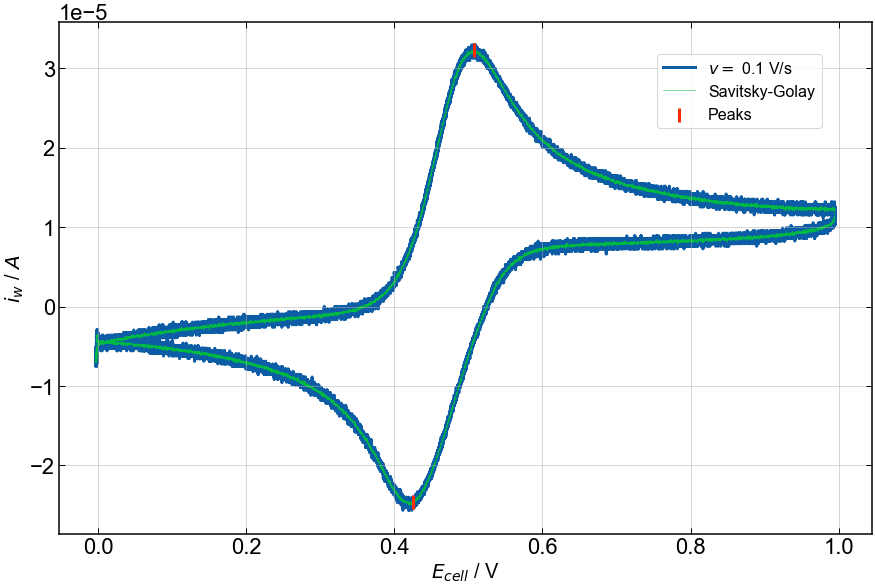

Saved
{'ipa': 2.8305513377934203e-05, 'Epa': 0.5094313021676499, 'ipc': -2.0708996838998044e-05, 'Epc': 0.4236516086802093}


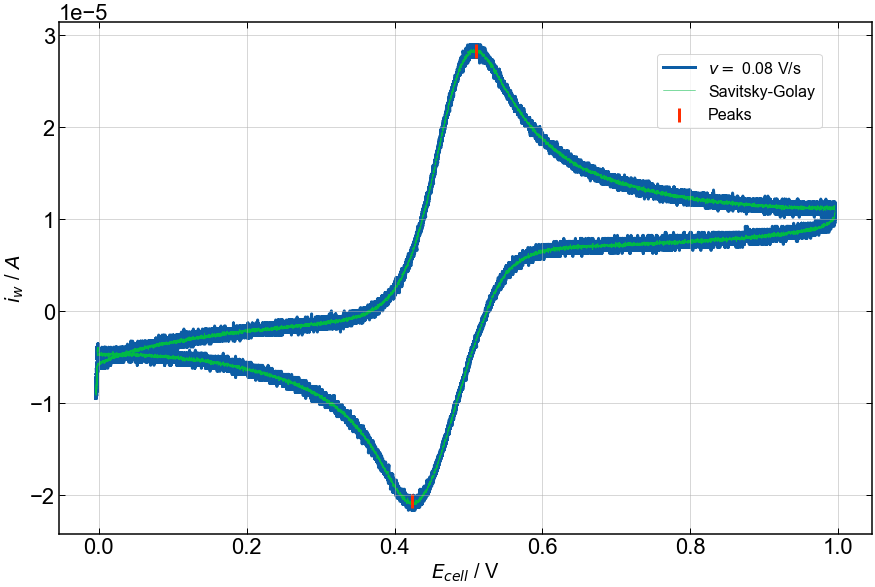

Saved
{'ipa': 2.633177463766793e-05, 'Epa': 0.5121945377788844, 'ipc': -1.7419432515243222e-05, 'Epc': 0.4282570009002074}


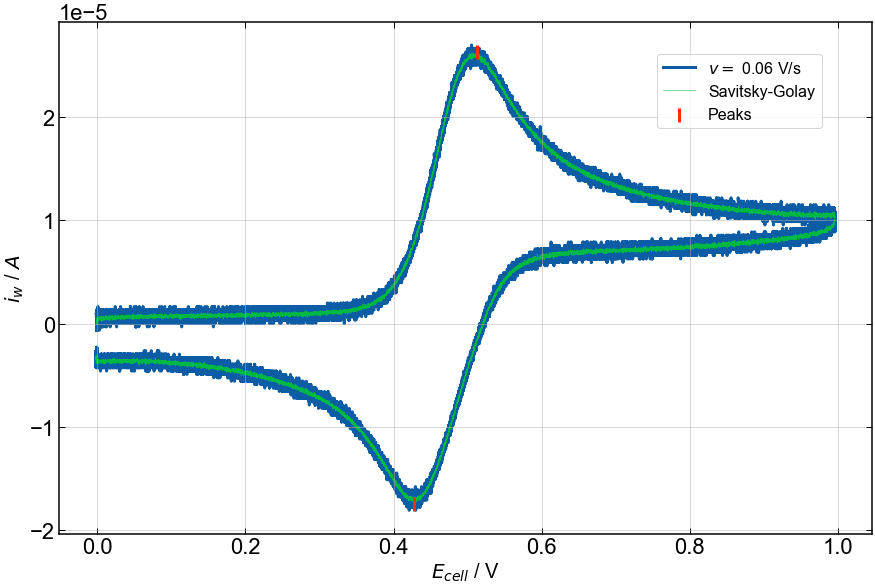

Saved
{'ipa': 2.17263842676539e-05, 'Epa': 0.5064706901784713, 'ipc': -1.3142998868323236e-05, 'Epc': 0.4286517477610897}


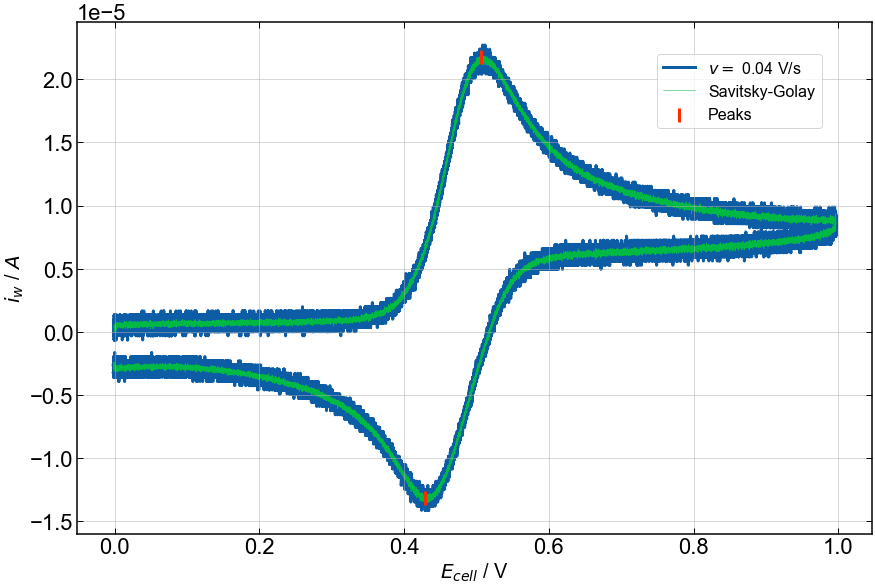

Saved


In [17]:
i = 0 # for setting savenames
for exp in exp_series:
    # Apply iR correction for Ru determined by EIS fitting to the Randles circuit
    Ru = 4.00e+02 # Ohms
    exp.data['Ecell'] = exp.data['Ecell'] - Ru * exp.data['iw'].abs() # 100% Compensation!

    # Smooth data using the Savitski Golay method
    exp.data['savgol_iw'] = savgol_filter(exp.data['iw'], 25, 2)

    # Maxima
    find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.
    ipa, Epa = exp.data['iw'][find_ipa[0]].to_numpy(), exp.data['Ecell'][find_ipa[0]].to_numpy()

    # Invert signal to find minima - Signals are negative but indicies are correct!
    find_ipc = find_peaks(-exp.data['savgol_iw'], height=0, width=3600) # Remember to un-invert anytime if calling ipc values from find_ipc, but not indicies.
    ipc, Epc = exp.data['iw'][find_ipc[0]].to_numpy(), exp.data['Ecell'][find_ipc[0]].to_numpy()

    peaks = {'ipa': ipa[0], 'Epa': Epa[0], 'ipc': ipc[0], 'Epc': Epc[0]}
    # df = pd.DataFrame(data=format(peaks), index=[CV.params.loc[CV.params['parameter']=='scan_rate', 'value'].item()]) # Gives a little table, but rounds values...
    print(peaks)


    # Now some plotting
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.plot(exp.data['Ecell'], exp.data['iw'], label = '$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s', zorder=0)
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'], color='C2', label='Savitsky-Golay', lw=.5, zorder=.5)
    ax.scatter([*Epa, *Epc], [*ipa, *ipc], color='C1', label='Peaks', marker='|', s=200, zorder=1)
    fig.tight_layout()

    ax.set_xlabel('$E_{cell}$ / V')
    ax.set_ylabel('$i_{w}$ / $A$')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend(loc=(0.75, 0.78))

    analyte = 'Fc_'
    electrode = 'GC_'
    solvent = 'MeCN'
    notebook = ['_P-07-02', '_P-07-04', '_P-07-05', '_P-07-06']

    plt.show()
    save_CV_fig(exp, fig, analyte, electrode, solvent, notebook[i])

    i += 1

#####